In [59]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from torch_geometric.utils.convert import from_networkx, to_networkx
import json
import os

import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv

## Data

Data source: https://snap.stanford.edu/data/feather-lastfm-social.html

In [60]:
# reading edges to a pandas dataframe
edges = pd.read_csv('./lasftm_asia/lastfm_asia_edges.csv')

In [61]:
# reading targets to a pandas dataframe
label = pd.read_csv('./lasftm_asia/lastfm_asia_target.csv')
label = label.drop(columns = ['id'])

In [62]:
# reading edges to a networkx Graph object
G=nx.from_pandas_edgelist(edges, 'node_1', 'node_2')

In [63]:
# reading node features
os.chdir('./lasftm_asia')

# Reading the json as a dict
with open('lastfm_asia_features.json') as json_data:
    features_data = json.load(json_data)
    
features = pd.DataFrame.from_dict(features_data, orient='index')
features = features.iloc[: , :100]
features.reset_index(drop=True, inplace=True)
label.reset_index(drop=True, inplace=True)
features = pd.concat([features, label], axis = 1)
features = features.fillna(0)

In [64]:
features[list(range(0, 100))].to_csv('features.csv',sep = ',', index = False)
feature_values = pd.read_csv('features.csv', sep = ';')
feature_values['y'] = features['target'].astype(str)
feature_values.columns = ['x','y']

In [65]:
# building a tensor - it should have features as a list 
features_data = feature_values.to_dict('index')
features_data = {key1: {key2:[float(val) for val in value2.split(',')] for key2, value2 in value1.items()}
                 for key1, value1 in features_data.items()}

In [66]:
# target should be just a value - not a list
for (k,v) in features_data.items():
    for (k2,v2) in v.items():
        if k2 == 'y':
            features_data[k][k2] =  int(features_data[k][k2][0])

In [67]:
# finalising the networkx Graph objects: adding node attributes
# making a pytorch graph object from a networkx Graph object
nx.set_node_attributes(G, features_data)
pyg_graph = from_networkx(G)
print(pyg_graph)
print(pyg_graph.x)

Data(x=[7624, 100], edge_index=[2, 55612], y=[7624])
tensor([[2964., 3900., 3902.,  ..., 2977., 6468., 3993.],
        [2397., 6371., 6028.,  ..., 5440., 6976., 4464.],
        [7375., 1890., 2400.,  ..., 6472., 2011., 1747.],
        ...,
        [2397., 3131., 1652.,  ..., 1581., 1976., 4702.],
        [1731., 5868., 3384.,  ...,  973., 5611.,    0.],
        [7176., 2135.,  287.,  ...,    0.,    0.,    0.]])


In [68]:
print(f'Number of nodes: {pyg_graph.x.shape[0]}')
print(f'Number of features: {pyg_graph.num_features}')
print(f'Has isolated nodes: {pyg_graph.has_isolated_nodes()}')

Number of nodes: 7624
Number of features: 100
Has isolated nodes: False


In [69]:
# Split the data 
test_ratio = 0.1
val_ratio = 0.2
num_nodes = pyg_graph.x.shape[0]
num_test = int(num_nodes * test_ratio)
num_val = int(num_nodes * val_ratio) + num_test
idx = [i for i in range(num_nodes)]

np.random.shuffle(idx)
test_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
test_mask[idx[:num_test]] = True
val_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
val_mask[idx[num_test:num_val]] = True
train_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
train_mask[idx[num_val:]] = True

print(train_mask)
# tensor([ True, False, False, False, False])
print(test_mask)
print(val_mask)

tensor([ True,  True,  True,  ...,  True, False, False])
tensor([False, False, False,  ..., False,  True, False])
tensor([False, False, False,  ..., False, False,  True])


In [70]:
pyg_graph.train_mask = train_mask
pyg_graph.test_mask = test_mask
pyg_graph.val_mask = val_mask

<BarContainer object of 98 artists>

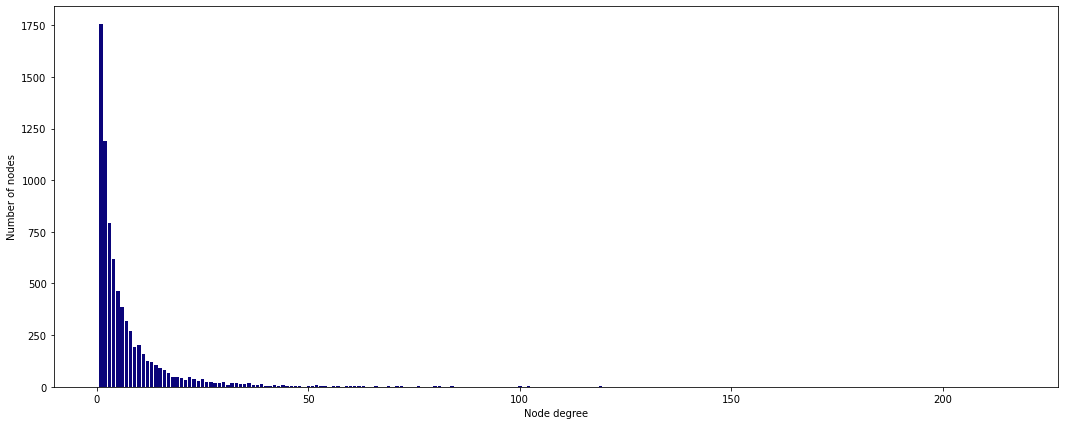

In [71]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(pyg_graph.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

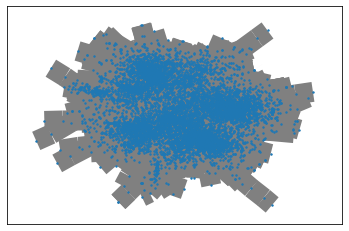

In [72]:
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=2,
                width=20,
                edge_color="grey"
                )

# DeepWalk

In [74]:
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [75]:
# get list of all nodes from the graph
all_nodes = list(G.nodes())

random_walks = []
for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))
        
# count of sequences
len(random_walks)

100%|████████████████████████████████████████████████████████████████████████████| 7624/7624 [00:05<00:00, 1468.35it/s]


38120

In [76]:
# train skip-gram (word2vec) model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(6586945, 6590320)

In [77]:
terms = list(G.nodes())

In [78]:
# generated embeddings
emb_df = pd.DataFrame(model.wv[terms])

[]

<Figure size 432x288 with 0 Axes>

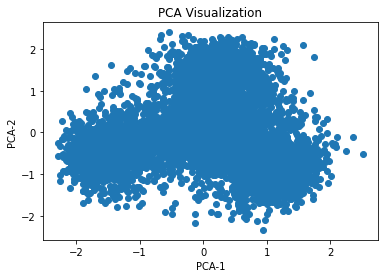

In [79]:
pca = PCA(n_components = 2, random_state = 7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)
emb_df_PCA['target'] = label['target']

plt.clf()
fig = plt.figure(figsize=(6,4))
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()

# node2vec

In [80]:
import node2vec
from node2vec import Node2Vec as n2v

In [81]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

g_emb = n2v(
  G,
  dimensions=16
)

mdl = g_emb.fit(
    vector_size = 16,
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)


Computing transition probabilities:   0%|          | 0/7624 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [02:05<00:00, 12.53s/it]


In [82]:
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)

[]

<Figure size 432x288 with 0 Axes>

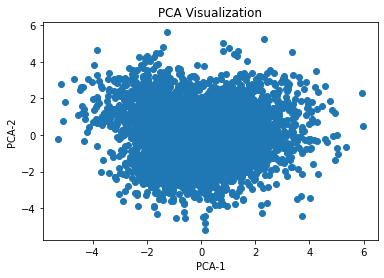

In [83]:
pca = PCA(n_components = 2, random_state = 7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)
plt.clf()
fig = plt.figure(figsize=(6,4))
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y']
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()

## Graph Attention Networks

In [84]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(x, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
          
    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [85]:
# Create GAT
gat = GAT(pyg_graph.num_features, 8, 18)
print(gat)

# Train
model = train(gat, pyg_graph)

# Test
acc = test(gat, pyg_graph)
print(f'GAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(100, 8, heads=8)
  (gat2): GATv2Conv(64, 18, heads=1)
)
Epoch   0 | Train Loss: 14145.873 | Train Acc:   5.73% | Val Loss: 14376.34 | Val Acc: 5.58%
Epoch  10 | Train Loss: 7104.688 | Train Acc:   7.70% | Val Loss: 7157.32 | Val Acc: 9.45%
Epoch  20 | Train Loss: 5185.025 | Train Acc:  10.49% | Val Loss: 5210.84 | Val Acc: 12.01%
Epoch  30 | Train Loss: 3825.700 | Train Acc:  11.03% | Val Loss: 3967.08 | Val Acc: 9.06%
Epoch  40 | Train Loss: 3471.081 | Train Acc:   9.91% | Val Loss: 3447.76 | Val Acc: 10.30%
Epoch  50 | Train Loss: 2468.965 | Train Acc:   9.95% | Val Loss: 2458.23 | Val Acc: 10.24%
Epoch  60 | Train Loss: 1869.386 | Train Acc:   9.87% | Val Loss: 1876.35 | Val Acc: 10.30%
Epoch  70 | Train Loss: 1521.831 | Train Acc:  10.38% | Val Loss: 1613.99 | Val Acc: 9.06%
Epoch  80 | Train Loss: 1315.264 | Train Acc:   9.63% | Val Loss: 1384.00 | Val Acc: 10.43%
Epoch  90 | Train Loss: 1033.808 | Train Acc:   7.66% | Val Loss: 945.45 | Val Acc: 8.20%
Epo

In [86]:
# Getting embeddings
model = GAT(pyg_graph.num_features, 8, 18)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.gat1.register_forward_hook(get_activation('gat1'))
output = model(pyg_graph.x, pyg_graph.edge_index)
print(activation['gat1'])

tensor([[-1648.3744,  3265.8350,   814.2103,  ...,  3621.3271, -1315.1166,
           833.8208],
        [ 4635.1704, -2312.4575,  1437.9260,  ...,  5413.9282, -6658.7471,
         -1789.8949],
        [ 3184.9851,  1330.7832, -2914.9578,  ...,  6541.0879, -4068.1250,
           -81.1357],
        ...,
        [ 3245.6619, -1660.9856,  1755.4294,  ...,  1554.1259, -2176.8723,
          3722.4895],
        [ 3735.2256,  2635.2002, -2545.2388,  ...,  5866.0010, -6740.7744,
          -909.3993],
        [ 3703.6267,  2023.5476, -1750.6659,  ...,  2357.8308, -5636.2954,
           849.3637]])


In [87]:
emb_df = pd.DataFrame(activation['gat1'].numpy())

[]

<Figure size 432x288 with 0 Axes>

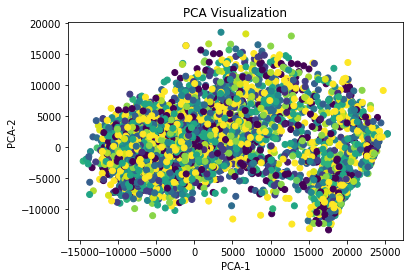

In [88]:
pca = PCA(n_components = 2, random_state = 7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)
emb_df_PCA['target'] = label['target']

plt.clf()
fig = plt.figure(figsize=(6,4))
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    c=emb_df_PCA['target'],
    
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()

## Graph Convolutional Networks

In [89]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

In [90]:
# Create GCN
gcn = GCN(pyg_graph.num_features, 16, 18)
print(gcn)

# Train
train(gcn, pyg_graph)

# Test
acc = test(gcn, pyg_graph)
print(f'GCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(100, 16)
  (gcn2): GCNConv(16, 18)
)
Epoch   0 | Train Loss: 6064.444 | Train Acc:   6.43% | Val Loss: 6039.43 | Val Acc: 7.22%
Epoch  10 | Train Loss: 9.922 | Train Acc:   6.18% | Val Loss: 11.62 | Val Acc: 5.71%
Epoch  20 | Train Loss: 3.145 | Train Acc:   7.62% | Val Loss: 2.90 | Val Acc: 6.76%
Epoch  30 | Train Loss: 2.809 | Train Acc:  20.96% | Val Loss: 2.79 | Val Acc: 20.21%
Epoch  40 | Train Loss: 2.803 | Train Acc:  20.94% | Val Loss: 2.76 | Val Acc: 20.21%
Epoch  50 | Train Loss: 2.784 | Train Acc:  16.94% | Val Loss: 2.66 | Val Acc: 17.78%
Epoch  60 | Train Loss: 2.647 | Train Acc:  16.90% | Val Loss: 2.71 | Val Acc: 17.78%
Epoch  70 | Train Loss: 2.582 | Train Acc:  16.90% | Val Loss: 2.90 | Val Acc: 17.78%
Epoch  80 | Train Loss: 2.570 | Train Acc:  16.92% | Val Loss: 2.58 | Val Acc: 17.85%
Epoch  90 | Train Loss: 2.615 | Train Acc:  20.91% | Val Loss: 2.87 | Val Acc: 20.08%
Epoch 100 | Train Loss: 2.586 | Train Acc:  20.93% | Val Loss: 2.96 | Val Ac

In [91]:
# Getting embeddings
model = GCN(pyg_graph.num_features, 16, 18)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.gcn1.register_forward_hook(get_activation('gcn1'))
output = model(pyg_graph.x, pyg_graph.edge_index)
print(activation['gcn1'])

tensor([[-3596.3760,  2423.8867, -5636.4756,  ..., -8793.2598, -3701.5002,
         -2327.2690],
        [-6165.4170,  4751.1763, -2910.7166,  ..., -8793.7246, -5412.8843,
          1546.0448],
        [-5139.5063,  1668.1434, -1711.2100,  ..., -6399.7891, -8110.1636,
          4022.2075],
        ...,
        [-5875.5371, 10222.2402, -5314.7637,  ..., -2608.7161, -3616.5386,
         -1321.0314],
        [ 5444.5513,   300.1178, -1864.1748,  ..., -8457.8311, -2665.8169,
         -1509.3577],
        [ -330.4158,  1414.7856,  -283.5490,  ..., -2670.7634,   858.1732,
          -834.7044]])


In [92]:
emb_df = pd.DataFrame(activation['gcn1'].numpy())

[]

<Figure size 432x288 with 0 Axes>

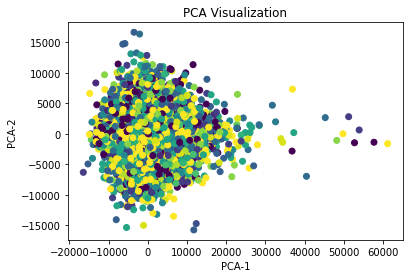

In [93]:
pca = PCA(n_components = 2, random_state = 7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)
emb_df_PCA['target'] = label['target']

plt.clf()
fig = plt.figure(figsize=(6,4))
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    c=emb_df_PCA['target'],
    
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()